In [1]:
import mxnet as mx
import numpy as np
import caffe as cf
from caffe import layers as L
import os,cv2
from mxnet2caffe import cvt_end2end

# used to show in page
from IPython.display import clear_output, Image, display, HTML
import time
import cv2
import base64

def arrayShow(imageArray):
    ret, png = cv2.imencode('.png', imageArray)
    encoded = base64.b64encode(png)
    return Image(data=encoded.decode('ascii'))


# from matplotlib import pyplot as plt
# %pylab inline

# def show_img(img):
#     fig = plt.imshow(img.clip(0,255))
#     fig.axes.get_xaxis().set_visible(False)
#     fig.axes.get_yaxis().set_visible(False)
#     plt.show()
# def show_rgb(img,ifswap=True):
#     img = np.transpose(img,axes=(1,2,0)).clip(0,255).astype(np.uint8)
#     if ifswap:
#         img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
#     fig = plt.imshow(img)
#     fig.axes.get_xaxis().set_visible(False)
#     fig.axes.get_yaxis().set_visible(False)
#     plt.show()
# def show_gray(img):
#     fig = plt.imshow(img)
#     fig.axes.get_xaxis().set_visible(False)
#     fig.axes.get_yaxis().set_visible(False)
#     plt.colorbar()
#     plt.show()
# def easyshow(src,title,ifcolorbar=True,cmap='gray'):
#     gci=plt.imshow(src,cmap=cmap)
#     plt.title(title)
#     if ifcolorbar:
#         plt.colorbar(gci)
#     plt.show()
#     return

def numpy_to_binary(src_arr, dst_fn):
    src_arr.astype(np.float32).tofile(dst_fn)
    return

def numpy_to_txt(src_arr, dst_fn):
    with open(dst_fn, 'wb') as f:
        for i, val in enumerate(src_arr.astype(np.float32).ravel()):
            line = '%f'%val
            if i % 10 == 9:
                line +='\r\n'
            else:
                line +=' '
            f.write(line)
    return

def save_cfnet_bin(srcnet, outfn):
    bytes_total =''
    for k,v in srcnet.params.items():
        for p in v:
            bytes_total += p.data.astype(np.float32).tobytes()
    
    with open(outfn, 'wb') as f:
        f.write(bytes_total)
    return

In [2]:
# src_sym_path = '/home/zcy6735/projects/style-transfer/models/model-0516/single-naive-82-inf.json'
# src_sym_path = '/home/zcy6735/projects/style-transfer/models/model-0522/0521-residualv2-inf.json'
# src_param_path = '/home/zcy6735/projects/style-transfer/models/model-0522/Picaso-styw-200000.000-tvw-phc0.100-phtv10.000-1.000-640-0007.params'
# src_sym_path = '/home/zcy6735/projects/style-transfer/models/model-0523/0522-inf.json'
# src_param_path = '/home/zcy6735/projects/style-transfer/models/model-0523/Picaso-mv2-styw-150000.000-tvw-phc0.100-phtv10.000-1.000-640-0010.params'

# src_sym_path = './models/0723/vg-coco-style3-octave-resinet-upsample-styw-800000.000-tvw-phc0.010-rcw10.000-noisew1.000-phtv0.000-2.000-640-symbol.json-inf.json'
# src_param_path = './models/0723/vg-coco-style3-octave-resinet-upsample-styw-800000.000-tvw-phc0.010-rcw10.000-noisew1.000-phtv0.000-2.000-640-0019.params'

src_sym_path = './models/0724/vg-coco-style3-big-octave-resinet-upsample-styw-600000.000-tvw-phc0.010-rcw10.000-noisew0.100-phtv0.000-2.000-640-symbol.json-inf.json'
src_param_path = './models/0724/vg-coco-style3-big-octave-resinet-upsample-styw-600000.000-tvw-phc0.010-rcw10.000-noisew0.100-phtv0.000-2.000-640-0001.params'

data_shp = {'data':[1, 3, 504, 896]}
out_prefix = './models/0724/loving-vicent'

In [3]:
cvt_end2end(src_sym_path, src_param_path, data_shp, out_prefix)

add Input layer: data
jump over arg: st-encoder-conv0_weight
jump over arg: st-encoder-instancenorm0_gamma
jump over arg: st-encoder-instancenorm0_beta
jump over arg: st-encoder-conv1_weight
jump over arg: st-encoder-instancenorm1_gamma
jump over arg: st-encoder-instancenorm1_beta
jump over arg: st-encoder-adaptivesequential2_instancenorm0_gamma
jump over arg: st-encoder-adaptivesequential2_instancenorm0_beta
jump over arg: st-encoder-adaptivesequential2_octconv0_W_HH-conv0_weight
jump over arg: st-encoder-adaptivesequential3_instancenorm0_gamma
jump over arg: st-encoder-adaptivesequential3_instancenorm0_beta
jump over arg: st-encoder-adaptivesequential3_octconv0_W_HH-conv0_weight
jump over arg: st-encoder-adaptivesequential2_octconv0_W_HL-conv0_weight
jump over arg: st-encoder-adaptivesequential3_instancenorm1_gamma
jump over arg: st-encoder-adaptivesequential3_instancenorm1_beta
jump over arg: st-encoder-adaptivesequential3_octconv0_W_LH-conv0_weight
jump over arg: st-encoder-adaptiv

In [4]:
class RGBImg2Tensor(object):
    def __init__(self, img_wh, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), aug=None):
        super(RGBImg2Tensor, self).__init__()
        self.img_wh = img_wh
        self.aug = aug
        self.mean = mean
        self.std = std

    def __call__(self, data):
        _rsz_img = mx.image.imresize(data, self.img_wh[0], self.img_wh[1], interp=1)
        _rsz_img = mx.nd.cast(_rsz_img, dtype='uint8')
        if self.aug:
            _rsz_img = self.aug(_rsz_img)
            _rsz_img = mx.nd.clip(_rsz_img, 0, 255)

        _imgtensor = mx.nd.image.to_tensor(_rsz_img)
        _imgtensor = mx.nd.image.normalize(
            _imgtensor, mean=self.mean, std=self.std)

        return _imgtensor

class Tensor2BGRImg(object):
    def __init__(self, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
        super(Tensor2BGRImg, self).__init__()
        self.mean = np.reshape(np.array(mean), (3, 1, 1))
        self.std = np.reshape(np.array(std), (3, 1, 1))
        return

    def __call__(self, data):
        inv_norm_img = (data * self.std + self.mean)
        inv_norm_img = np.transpose(
            255 * inv_norm_img, axes=(1, 2, 0)).clip(0, 255).astype(np.uint8)
        bgr_inv_norm_img = cv2.cvtColor(inv_norm_img, cv2.COLOR_RGB2BGR)
        return bgr_inv_norm_img

In [5]:
pre, post = RGBImg2Tensor((896,504)), Tensor2BGRImg()
# srcimg_fn = '/home/zcy6735/projects/style-transfer/data/content/portrit.png'
srcimg_fn = '/mnt/data/dataset/ShutterStock/shutterstock_3273930.jpg'
srcimg_mx = mx.image.imread(srcimg_fn)
srcimg_np = pre(srcimg_mx).asnumpy()
srcimg_np = np.expand_dims(srcimg_np,axis=0)

In [6]:
#initialize caffe network
import caffe as cf
transfer_net = cf.Net(out_prefix + '.prototxt', out_prefix+ '.caffemodel', cf.TEST)

In [7]:
transfer_net.blobs['data'].data[...] = srcimg_np

In [8]:
transfer_net.forward()
outkey = transfer_net.blobs.keys()[-1]
transfered_data = transfer_net.blobs[outkey].data[0]

In [9]:
res_img = post(transfered_data)

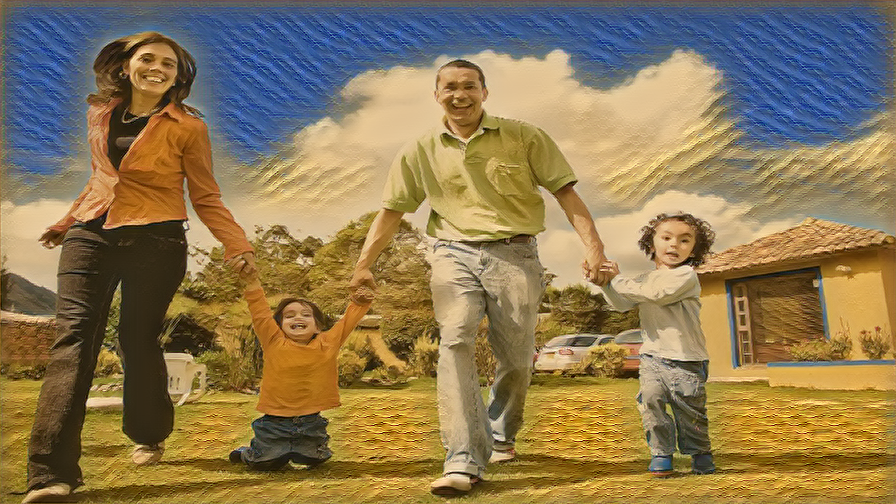

In [10]:
res2show = arrayShow(res_img)
display(res2show)


In [ ]:
cv2.imwrite('./cf-out.jpg',res_img)

In [ ]:
import mxnet as mx

In [ ]:
mx.nd.sigmoid?

In [ ]:
cf.Layer??

In [ ]:
cf.layer_types_list()

In [ ]:
a = cf.layer_type_list()

In [ ]:
list(a)

In [ ]:
cf.ti